## Vehicle Detection Project   
   
The goals / steps of this project are the following:   
   
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier   
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.   
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.   
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.   
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.   
* Estimate a bounding box for vehicles detected.   

### Histogram of Oriented Gradients (HOG)   
   
1. Explain how you extracted HOG features from the training images.   
   
I started by reading in all the vehicle and non-vehicle images. 

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline
import matplotlib.pyplot as plt

number of car images:  8792
number of non-car images:  8968



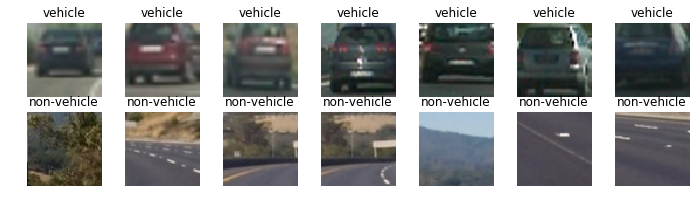

In [15]:
IMAGE_SHAPE = (64,64,3)

def load_images(glob_path):
    files = glob.glob(glob_path)
    images = np.zeros((len(files), *IMAGE_SHAPE), dtype=np.uint8)
    for i, f in enumerate(files):
        images[i] = cv2.imread(f)
        images[i] = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    return images

car_images = load_images("vehicles/*/*.png")        
noncar_images = load_images("non-vehicles/*/*.png")
print("number of car images: ", len(car_images))
print("number of non-car images: ", len(noncar_images))

WHICH = [1, 88, 128, 168, 388, 488, 588,]
plt.figure(figsize=(12,3))
for i, which in enumerate(WHICH):
    p = plt.subplot(2, len(WHICH), i+1)
    p.axis("off")
    p.set_title("vehicle")
    p.imshow(car_images[which])
    p = plt.subplot(2, len(WHICH), len(WHICH)+i+1)
    p.axis("off")
    p.set_title("non-vehicle")
    p.imshow(noncar_images[which])
print()


I then used YCrCb color space and set skimage.hog() parameters. I grabbed one images from each of the two classes and displayed them to get a feel for what the skimage.hog() output looks like.  
  
Here is an example using the Y channel of YCrCb color space and HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):  

1) output_images/car.jpg  
2) output_images/car_hog.jpg  
3) output_images/non_car.jpg  
4) output_images/non_car_hog.jpg  
  
2. Explain how you settled on your final choice of HOG parameters.  
 
The code is in function hog_features()  
   
I tried some combinations, and looked like Y channel gave the best figure. But when later moved to train a SVM, I realized all 3 channels were more useful than color space features  

car_image saved
car_hog_image saved
non_car_image saved
non_car_hog_image saved



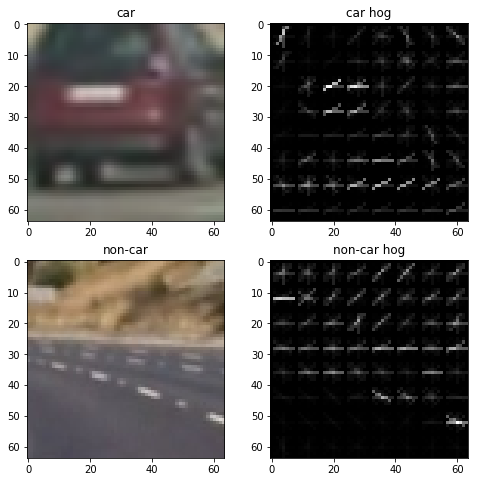

In [16]:
def hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    # choose Y channel
    img_y = (cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))[:,:,0]
    if vis == True:
        features, hog_image = hog(img_y, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img_y, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
WHICH = 88
car_hog_features, car_hog_image = hog_features(car_images[WHICH], orient=8, 
                                                           pix_per_cell=8, cell_per_block=2,
                                                          vis=True, feature_vec=True)
noncar_hog_features, noncar_hog_image = hog_features(noncar_images[WHICH], orient=8, 
                                                           pix_per_cell=8, cell_per_block=2,
                                                          vis=True, feature_vec=True)

plt.figure(figsize=(8,8))
p = plt.subplot(2, 2, 1)
p.set_title("car")
p.imshow(car_images[WHICH])
save = cv2.cvtColor(car_images[WHICH], cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/car.jpg', save):
    print("car_image saved")
p = plt.subplot(2, 2, 2)
p.set_title("car hog")
p.imshow(car_hog_image, cmap='gray')
save = np.uint8(car_hog_image/np.max(car_hog_image) *255)
if True == cv2.imwrite('output_images/car_hog.jpg', save):
    print("car_hog_image saved")
p = plt.subplot(2, 2, 3)
p.set_title("non-car")
p.imshow(noncar_images[WHICH])
save = cv2.cvtColor(noncar_images[WHICH], cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/non_car.jpg', save):
    print("non_car_image saved")
p = plt.subplot(2, 2, 4)
p.set_title("non-car hog")
p.imshow(noncar_hog_image, cmap='gray')
save = np.uint8(noncar_hog_image/np.max(noncar_hog_image) *255)
if True == cv2.imwrite('output_images/non_car_hog.jpg', save):
    print("non_car_hog_image saved")
print()

3. Describe how you trained a classifier using your selected HOG features (and color features if you used them).  

I combined both HOG features, which located in function hog_features_3(), and color space features, which located in functions color_features(), hist_features().   

In the initial try, I grapped hog features only from Y channel. But when trained the classifier, I realized too many color space features would gave lots of false detections. In order to increase the propotions of hog features, I then grapped them from all 3 channels. The result looked much better.  

Then in function process_features() , I used StandardScaler() to normalize all the features, and prepared corresponding labels. 
  
To verify the trainning result, I used train_test_split() to split features to trainning set and testing set.

Finally I used a liner SVC to do the trainning, the verifying result showed a 99.2% accuracy which was surprising.


1) output_images/scaled_features.png  
shows the comparsion of non-scaled features and scaled features for a car image which dominated by red color.

In [17]:
# Depending on color would give too many false detection, so prefer more hog
def hog_features_3(img, orient=8, pix_per_cell=8, cell_per_block=2, feature_vec=True):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    ch1 = ycrcb[:,:,0]
    ch2 = ycrcb[:,:,1]
    ch3 = ycrcb[:,:,2]
    
    hog1 = hog(ch1, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       feature_vector=feature_vec)
    hog2 = hog(ch2, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       feature_vector=feature_vec)
    hog3 = hog(ch3, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       feature_vector=feature_vec)
    return hog1, hog2, hog3


# Define a function to compute binned color features  
def color_features(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
def extract_features(imgs, spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:    
        # Apply color_features() to get spatial color features
        color_f = color_features(img, size=spatial_size)
        # Apply hist_features() also with a color space option now
        hist_f = hist_features(img, nbins=hist_bins, bins_range=hist_range)
        # Apply hog_features_3()
        hog_1,hog_2,hog_3 = hog_features_3(img, orient=8, pix_per_cell=8, 
                     cell_per_block=2, feature_vec=True)
        hog_f = np.hstack((hog_1, hog_2, hog_3))
        # Append the new feature vector to the features list
        features.append(np.concatenate((color_f, hist_f, hog_f)))
    # Return list of feature vectors
    return features

car_features = extract_features(car_images)
noncar_features = extract_features(noncar_images)
print("number of features for a object: ", len(car_features[0]))

number of features for a object:  5568


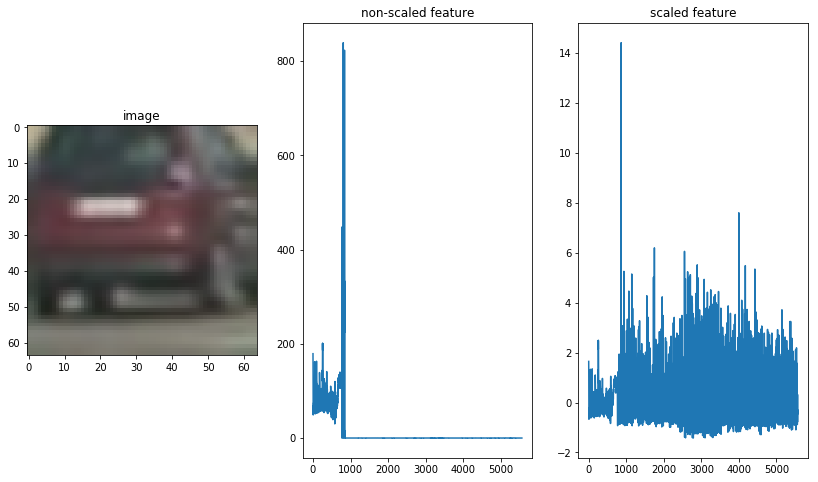

In [18]:
# normalize features and generate labels
def process_features(car_features, noncar_features):
    # Create an array stack of feature vectors
    x = np.vstack((car_features, noncar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(x)
    # Apply the scaler to X
    scaled_x = X_scaler.transform(x)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
    return x,scaled_x, y, X_scaler

original_features, features, labels, X_scaler = process_features(car_features, noncar_features)

WHICH = 88

plt.figure(figsize=(14,8))
p = plt.subplot(1, 3, 1)
p.set_title("image")
p.imshow(car_images[WHICH])
save = cv2.cvtColor(car_images[WHICH], cv2.COLOR_RGB2BGR)
p = plt.subplot(1, 3, 2)
p.set_title("non-scaled feature")
p.plot(original_features[WHICH])
p = plt.subplot(1, 3, 3)
p.set_title("scaled feature")
p.plot(features[WHICH])
print()

In [19]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=rand_state)
    
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(x_train, y_train)

print('Test Accuracy of SVC = ', svc.score(x_test, y_test))

Test Accuracy of SVC =  0.992398648649


### Sliding Window Search 

1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?   

I implemented Hog Sub-sampling Window Search in function find_cars() , and set scale=1.5, orient=8, pix_per_cell=8, cell_per_block=2  . It extracted hog features once and then sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%.

These parameters were decided by experiements, since they were good enough from the beginning, I didn't do many changes.  

2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?  
  
Ultimately I searched on YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector. To minimize the workload, I clipped image on Y-axis in range (300, 700) 

Example images:  
1) output_images/windows_search_test1.jpg  
2) output_images/windows_search_test2.jpg  
3) output_images/windows_search_test3.jpg  
4) output_images/windows_search_test4.jpg  
5) output_images/windows_search_test5.jpg  
6) output_images/windows_search_test6.jpg  

windows_search_test1 saved
windows_search_test2 saved
windows_search_test3 saved
windows_search_test4 saved
windows_search_test5 saved
windows_search_test6 saved


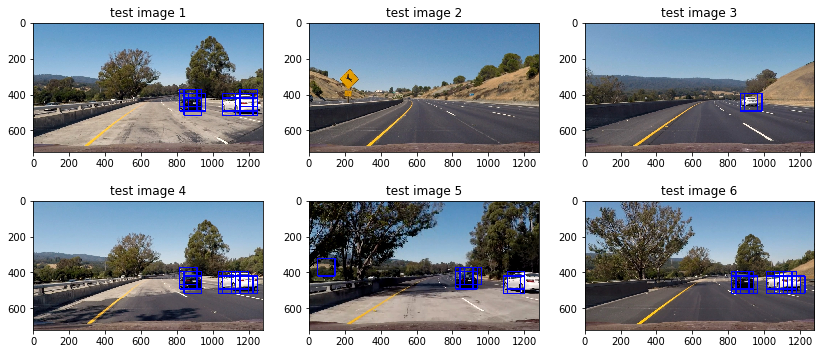

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1,hog2,hog3 = hog_features_3(img_tosearch, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_f = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            color_f = color_features(subimg)
            hist_f = hist_features(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((color_f, hist_f, hog_f)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list
    
ystart = 300
ystop = 700
scale = 1.5

plt.figure(figsize=(14,6))
test_img = cv2.imread("test_images/test1.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
p = plt.subplot(2, 3, 1)
p.imshow(out_img)
p.set_title("test image 1")
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/windows_search_test1.jpg', save):
    print("windows_search_test1 saved")
    
test_img = cv2.imread("test_images/test2.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
p = plt.subplot(2, 3, 2)
p.imshow(out_img)
p.set_title("test image 2")
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/windows_search_test2.jpg', save):
    print("windows_search_test2 saved")

test_img = cv2.imread("test_images/test3.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
p = plt.subplot(2, 3, 3)
p.set_title("test image 3")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/windows_search_test3.jpg', save):
    print("windows_search_test3 saved")

test_img = cv2.imread("test_images/test4.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
p = plt.subplot(2, 3, 4)
p.set_title("test image 4")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/windows_search_test4.jpg', save):
    print("windows_search_test4 saved")    
    
test_img = cv2.imread("test_images/test5.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
p = plt.subplot(2, 3, 5)
p.set_title("test image 5")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/windows_search_test5.jpg', save):
    print("windows_search_test5 saved")
    
test_img = cv2.imread("test_images/test6.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
p = plt.subplot(2, 3, 6)
p.set_title("test image 6")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/windows_search_test6.jpg', save):
    print("windows_search_test6 saved")


### Video Implementation

1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.) 

Here's a link to my video result:  https://www.youtube.com/watch?v=bbmTBb1zpho

2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.  

My design was based on a frames FIFO as the filter, heat values in the FIFO would be summed up before sent to threshold and label functions. The FIFO windows was 48 depth, and the heat threshold was 60 which worked well on the project video.

In the example, I chose test images 4, 5, 6 which looked like in consecutive to test my FIFO design.  
     
1) one stacked frame result:   
   a) output_images/1_frame_stacked_heatmap.jpg  
   b) output_images/1_frame_stacked_label_image.jpg  
     
2) two stacked frames result:   
   a) output_images/2_frame_stacked_heatmap.jpg   
   b) output_images/2_frame_stacked_label_image.jpg   
     
3) three stacked frames result:   
   a) output_images/3_frame_stacked_heatmap.jpg   
   b) output_images/3_frame_stacked_label_image.jpg   
     
Obervered the stacked ( filtered ) result images, the false detection in test_images_5 disappeared.    
   


1_frame_stacked_label_image saved
1_frame_stacked_heatmap saved
2_frame_stacked_label_image saved
2_frame_stacked_heatmap saved
3_frame_stacked_label_image saved
3_frame_stacked_heatmap saved


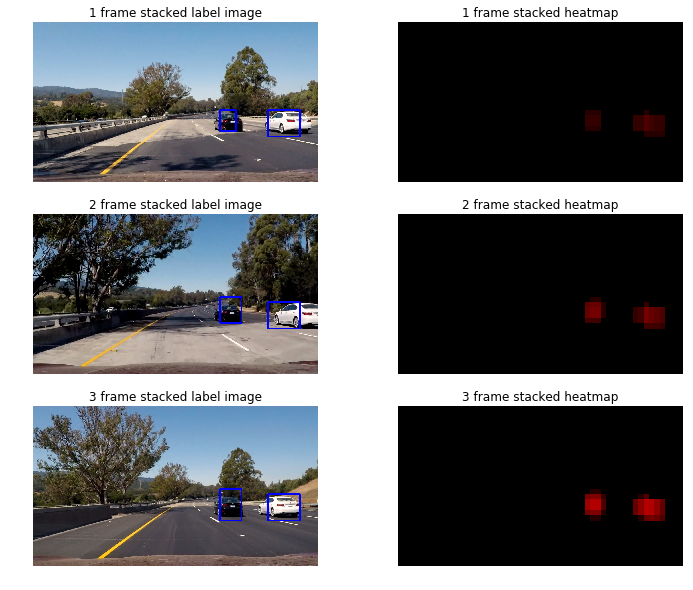

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_heat(heat, image, bbox_list):
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list) 
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap, labels

ystart = 300
ystop = 700
scale = 1.5

plt.figure(figsize=(12,10))
test_img = cv2.imread("test_images/test4.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# heat will be stacked up by each image
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
out_img, heatmap, labels = find_heat(heat, test_img, bbox_list)
p = plt.subplot(3, 2, 1)
p.set_title("1 frame stacked label image")
p.axis("off")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/1_frame_stacked_label_image.jpg', save):
    print("1_frame_stacked_label_image saved")
heatmap = (heatmap/20 *255).astype(np.uint8)
heatmap = np.dstack(( heatmap, np.zeros_like(heatmap), np.zeros_like(heatmap)))
p = plt.subplot(3, 2, 2)
p.set_title("1 frame stacked heatmap")
p.axis("off")
p.imshow(heatmap)
save = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/1_frame_stacked_heatmap.jpg', save):
    print("1_frame_stacked_heatmap saved")
    
test_img = cv2.imread("test_images/test5.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
out_img, heatmap, labels = find_heat(heat, test_img, bbox_list)
p = plt.subplot(3, 2, 3)
p.set_title("2 frame stacked label image")
p.axis("off")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/2_frame_stacked_label_image.jpg', save):
    print("2_frame_stacked_label_image saved")
heatmap = (heatmap/20 *255).astype(np.uint8)
heatmap = np.dstack(( heatmap, np.zeros_like(heatmap), np.zeros_like(heatmap)))
p = plt.subplot(3, 2, 4)
p.set_title("2 frame stacked heatmap")
p.axis("off")
p.imshow(heatmap)
save = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/2_frame_stacked_heatmap.jpg', save):
    print("2_frame_stacked_heatmap saved")
    
test_img = cv2.imread("test_images/test6.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
out_img, bbox_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
out_img, heatmap, labels = find_heat(heat, test_img, bbox_list)
p = plt.subplot(3, 2, 5)
p.set_title("3 frame stacked label image")
p.axis("off")
p.imshow(out_img)
save = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/3_frame_stacked_label_image.jpg', save):
    print("3_frame_stacked_label_image saved")
heatmap = (heatmap/20 *255).astype(np.uint8)
heatmap = np.dstack(( heatmap, np.zeros_like(heatmap), np.zeros_like(heatmap)))
p = plt.subplot(3, 2, 6)
p.set_title("3 frame stacked heatmap")
p.axis("off")
p.imshow(heatmap)
save = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
if True == cv2.imwrite('output_images/3_frame_stacked_heatmap.jpg', save):
    print("3_frame_stacked_heatmap saved")

In [31]:
# FIFO version of find_heat
def find_heat_fifo(image, bbox_list, fifo_depth, threshold, heat_fifo=[] ):
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list) 
    # Append the new heat to heat_fifo
    heat_fifo.append(heat)
    # Pop up if exceed the FIFO size
    while len(heat_fifo) > fifo_depth:
        heat_fifo.pop(0)
    # Sum up the heat FIFO
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    for h1 in heat_fifo:
        heat = heat + h1
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    ## Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(image, labels)
    return draw_img

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
def process_image(img):
    ystart = 300
    ystop = 700
    scale = 1.5
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=8, pix_per_cell=8, cell_per_block=2)
    out_img = find_heat_fifo(img, bbox_list, fifo_depth=48, threshold=60)
    return out_img
    
movie_output = 'processed_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
movie_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time movie_clip.write_videofile(movie_output, audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:57<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

Wall time: 14min 58s


In [37]:
HTML("""
<video width="640" height="480" controls>
  <source src="{0}">
</video>
""".format(movie_output))

### Discussion 

1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust? 
  
In the initial try, I used only Y channel to grap HOG features. Then found dominant color features gave too many false detections.  Then I changed to grap HOG features from all 3 channels to make it dominating instead.    
   
To get rid of false detections in the video, I chose to implment a FIFO with 48 depth ( 2 seconds ), which I believed enough to filter out the noises. But the heat threshold turned out to be hard to adjust, I needed to find a balance point which could satify both removing false detections and retaining true detections.  The parameter 60 I finnally chose might not work on other videos.

FIFO size 48 raised another problem, the system became not insensitive to sudden change, e.g. a very high speed vehicle poped up.  I need to think about it.